In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#Importing Libraries
import pandas as pd
import numpy as np

import re
import nltk
from tqdm import tqdm
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#Simply Reading the Data
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [ ]:
train_data.info()
#We have 7613 Features for training the data

In [ ]:
train_data.dropna().head()
#Here we have keyword and location as categorical features and text as simple text features

In [ ]:
train_data['target'].value_counts()
#Here we can see that, our data is imbalanced but it's not that much imbalanced

In [ ]:
null_values = train_data.isnull().sum()
for index in range(len(train_data.columns)):
    if null_values[index] > 0:
        print('{:.2f}% ({}) Null Values Present in "{}" Feature'.format(null_values[index]/len(train_data)*100,
                                                              null_values[index], train_data.columns[index]))
#We have a small chunk of keyword values as null
#but in Location feature we have almost 1/3 part as missing
#For now we will be using only keyword and text feature for modeling

In [ ]:
#Let's fill missing values in Keywords
train_data['keyword'].fillna(method = 'backfill', inplace = True)
train_data['keyword'].fillna(method = 'ffill', inplace = True)
test_data['keyword'].fillna(method = 'backfill', inplace = True)
test_data['keyword'].fillna(method = 'ffill', inplace = True)

In [ ]:
#First Let's clean the text column below are the some operations we will be performing on this textual data
def decontration(text):
    #below contractons are specific to words and cannot be solved by general solution
    text = re.sub(r"aren't", 'are not', text)
    text = re.sub(r"won't", 'will not', text)
    text = re.sub(r"doesn't", 'does not', text)
    #Below contractions are general and works for most of the word
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text.lower()

def cleaning_text(text):  
    #Below one line of code is inspired by https://stackoverflow.com/questions/24399820/expression-to-remove-url-links-from-twitter-tweet/24399874
    text = re.sub(r'http\S+', ' ', text)
    text = decontration(text)
    text  = re.sub('[^A-Za-z0-9]+', ' ', text)
    #Removing Stopwords
    stop_words = set(stopwords.words('english'))
    processed_list = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return " ".join(processed_list)

In [ ]:
#Just applying the text cleaning functions to all the values of text column training data
preprocessed_text = []
for text in tqdm(train_data['text']):
    preprocessed_text.append(cleaning_text(text))
train_data['text'] = preprocessed_text

#Just applying the text cleaning functions to all the values of text column of test data
preprocessed_text = []
for text in tqdm(test_data['text']):
    preprocessed_text.append(cleaning_text(text))
test_data['text'] = preprocessed_text

In [ ]:
#Now Let's Split our data into train and test just find the best hyper parameters
X = train_data[['keyword', 'text']]
y = train_data['target']
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [ ]:
#Here we are using simple Count Vectorizer
vectorizer = CountVectorizer(min_df=3)
X_train_text = vectorizer.fit_transform(X_train['text'])
X_test_text = vectorizer.transform(X_test['text'])
test_text = vectorizer.transform(test_data['text']) 

#Printing the shape of the data
print("Vectorized Training Text Data Shape    : ", X_train_text.shape)
print("Vectorized Testing Text Data Shape     : ", X_test_text.shape)
print("Vectorized Real Testing Text Shape     : ", test_text.shape)

In [ ]:
#Here we are using simple Count Vectorizer
vectorizer = CountVectorizer()
X_train_keyword = vectorizer.fit_transform(X_train['keyword'])
X_test_keyword = vectorizer.transform(X_test['keyword']) 
test_keyword = vectorizer.transform(test_data['keyword']) 

#Printing the shape of the data
print("Vectorized Training Data Shape    : ", X_train_keyword.shape)
print("Vectorized Testing Data Shape     : ", X_test_keyword.shape)
print("Vectorized Testing Data Shape     : ", test_keyword.shape)

In [ ]:
#Just Stacking or combining all the data
X_train_final = np.hstack((X_train_text.toarray(), X_train_keyword.toarray()))
X_test_final = np.hstack((X_test_text.toarray(), X_test_keyword.toarray()))
testing_data = np.hstack((test_text.toarray(), test_keyword.toarray()))

In [ ]:
#Here We will be using simple Logistic Regression Model
#Also we are using GridSearch to find the best hyperparameter value
parameters = {'alpha' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
sgd_clf = SGDClassifier(class_weight='balanced', penalty='l2', loss='log', random_state=910)
clf = GridSearchCV(sgd_clf, parameters, n_jobs = -1, cv = 5, scoring = make_scorer(f1_score))
clf.fit(X_train_final, y_train)
clf.best_params_

In [ ]:
#Now When we have our best hyperparamter let's train our model
sgd_clf = SGDClassifier(alpha = 0.001, class_weight='balanced', penalty='l2', loss='log', random_state=910)
sgd_clf.fit(X_train_final, y_train)

In [ ]:
train_preds = sgd_clf.predict(X_train_final)
test_preds = sgd_clf.predict(X_test_final)

print("Train Score ", f1_score(y_train, train_preds))
print('Test Score ', f1_score(y_test, test_preds))

#Here We can see that our training and testing score is not that much apart
#and that's why we can say model is not overfitting

In [ ]:
#Now let's predict on the actual testing data and create the submission file
submission_file = pd.DataFrame({'id':test_data['id'], 'target':sgd_clf.predict(testing_data)})
submission_file.to_csv("submission_file.csv", index=False)

#I got 0.79 Score, we can increase the score with few other changes
#1. We can use Location Feature
#2. We can try different techniques of vectorization
#3. Different Model might be helpful
#4. Stacking or DeepLearning will surely be beneficial

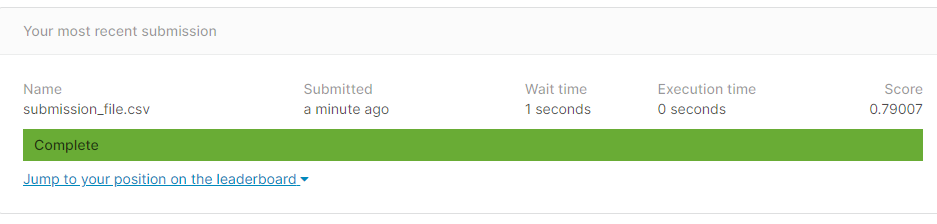

**Any Suggestion or Correction will be appreciated.**